# <font color='blue'>Data Science </font> & <font color = 'gold'> The Blockchain </font>

**Authors: Max Miranda, Jai Yarlagadda**             

**Credits to: Github User: yanofsky, Stackoverflow Users: MrPromethee & Mandrek**

The goal of this project was to take the last 3240 tweets (that's the number twitter's API allows for) from Coindesk's Twitter Account, and to apply natural language processing and data science tools to analyze what these tweets for sentiments towards cryptocurrencies. 

Tools: 
*  *Tweepy* : in order to find the tweets 
*  *TextBlob* : for sentiment analysis) 
*  *Pandas* : data structure, all the table manipulation
*  *Matplotlib* : draws pretty graphs
*  *Numpy & SciPy* : sets of pre-written math functions

In [220]:
################### For Parts 1-7 ####################
from datascience import *
import numpy as np
import scipy 

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

######## For Prediction Techniques (8-10) ############
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from client.api.notebook import Notebook
ok = Notebook('exploration.ok')
_ = ok.auth(inline=True)

ModuleNotFoundError: No module named 'quandl'

## 1. A tale of two tables:

The first step was to gain access to the Twitter API, which can be done really simply on apps.twitter.com. Which, as it turns out, is incredibly simple:

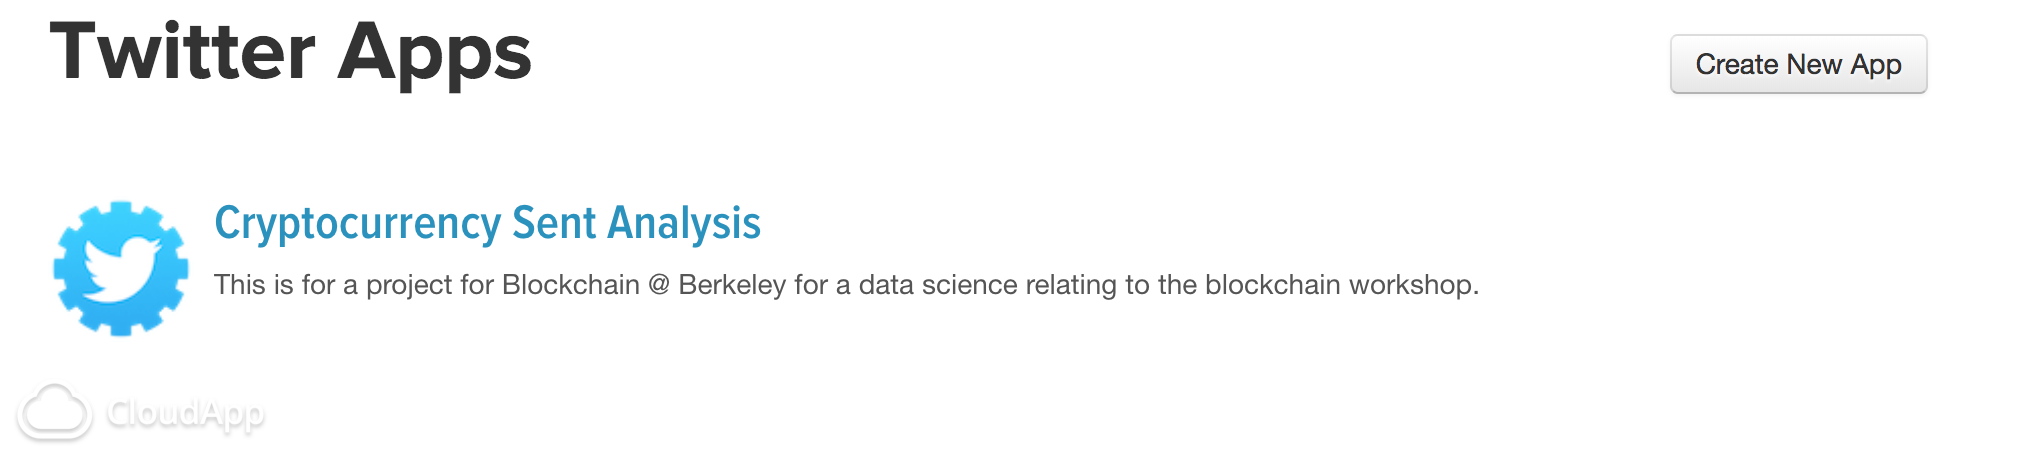


The next was to be able to conduct simple positive or negative sentiment analysis on the data, which we used a Github Gist on dumping tweets from a twitter account that we combined with information on a StackOverflow post on how to conduct sentiment analysis using TextBlobber. (Thanks yanofsky, MrPromthee, & Mandrek).

The result was the following code: __[tweet_sentiment_anal.py](https://gist.github.com/maxmiranda/e3ce6cb8becae7b98a0f1a7df9469c4a)__

We used *that* to produce the `coindesk_tweets_sentiments.csv` table.

In [124]:
coindesk_tweets = Table.read_table("coindesk_tweets_sentiments.csv", encoding = "latin1")
print(coindesk_tweets.where("sentiment", "Positive").num_rows)
print(coindesk_tweets.where("sentiment", "Negative").num_rows)
print(coindesk_tweets.where("sentiment", "Neutral").num_rows)

coindesk_tweets

2082
948
190


content,sentiment
The last panel of #ConsensusInvest2017 is underway. Catc ...,Negative
Live from #ConsensusInvest2017 with @SkyCorridors https: ...,Neutral
Breaking out the most successful ICOs to date #Consensus ...,Positive
Live from #ConsensusInvest2017 with @jimmysong https://t ...,Neutral
Tetras Capital's @alexsunnarborg on valuations for store ...,Negative
Tetras Capital's @alexsunnarborg breaks down how to rese ...,Positive
Live from #ConsensusInvest2017 with @TuurDemeesterzx htt ...,Neutral
"Cryptocurrency is set for a ""mass market moment"" accordi ...",Positive
Up next: analyst @TuurDemeester takes the stage at #Cons ...,Positive
Live from #ConsensusInvest2017 with @CremeDeLaCrypto htt ...,Neutral


`coindesk_tweets` will serve as our source table, and will help us to create two tables. One that keeps track of the number of mentions (a quantitative variable), and one that keeps track of general sentiment (a categorical variable).

First, one that counts the amount of mentions for a list of cryptocurrencies. 

In [175]:
cryptos = make_array("Bitcoin", "Ethereum", "Ripple", "Bitcoin Cash", "Bitconnect", "Dash", "Ethereum Classic", "Iota", "Litecoin", "Monero","Nem","Neo","Numeraire","Stratis","Waves" )

num_mentions = make_array()

for crypto in cryptos: 
    num_mentions_for_one_capitalized = coindesk_tweets.where('content', are.containing(crypto)).num_rows
    num_mentions_for_one_upper = coindesk_tweets.where('content', are.containing(crypto.upper())).num_rows
    num_mentions_for_one_lower = coindesk_tweets.where('content', are.containing(crypto.lower())).num_rows
    
    num_mentions_for_one = num_mentions_for_one_lower + num_mentions_for_one_upper + num_mentions_for_one_capitalized
    num_mentions = np.append(num_mentions, num_mentions_for_one)
cryptos_num_mentions = Table().with_columns("crypto", cryptos,
                                         "num of mentions", num_mentions)
cryptos_num_mentions.show(len(cryptos))

crypto,num of mentions
Bitcoin,1142
Ethereum,156
Ripple,40
Bitcoin Cash,76
Bitconnect,0
Dash,5
Ethereum Classic,1
Iota,1
Litecoin,14
Monero,9


Now, time for the crytocurriences vs. their coindesk sentiment. First, we will create a new table that has both the original coindesk tweets and lists any cryptos mentioned. 

In [176]:
cryptos_for_tweets = []

for tweet in coindesk_tweets.column("content"): # creating new column that can be appended to coindesk_tweets to give easy access to which tweets reference which cryptos   
    cryptos_for_a_tweet = []
    for crypto in cryptos: 
        if tweet.rfind(crypto) != -1:
            cryptos_for_a_tweet.append(crypto)
    
    cryptos_for_tweets.append(cryptos_for_a_tweet)
        
cryptos_tweets = coindesk_tweets.with_column("crypto mentioned", cryptos_for_tweets)

cryptos_tweets

content,sentiment,crypto mentioned
The last panel of #ConsensusInvest2017 is underway. Catc ...,Negative,[]
Live from #ConsensusInvest2017 with @SkyCorridors https: ...,Neutral,[]
Breaking out the most successful ICOs to date #Consensus ...,Positive,[]
Live from #ConsensusInvest2017 with @jimmysong https://t ...,Neutral,[]
Tetras Capital's @alexsunnarborg on valuations for store ...,Negative,[]
Tetras Capital's @alexsunnarborg breaks down how to rese ...,Positive,[]
Live from #ConsensusInvest2017 with @TuurDemeesterzx htt ...,Neutral,[]
"Cryptocurrency is set for a ""mass market moment"" accordi ...",Positive,[]
Up next: analyst @TuurDemeester takes the stage at #Cons ...,Positive,[]
Live from #ConsensusInvest2017 with @CremeDeLaCrypto htt ...,Neutral,[]


Now, to finally create the second table we will subtract the number of positive tweets by the number of negative tweets, to gain a general sentiment.

In [184]:
sentiments = make_array()

for crypto in cryptos: 
    positive_num = cryptos_tweets.where("crypto mentioned", are.containing(crypto)).where("sentiment", "Positive").num_rows
    negative_num = cryptos_tweets.where("crypto mentioned", are.containing(crypto)).where("sentiment", "Negative").num_rows
    if positive_num - negative_num > 0: 
        sentiment = "Positive"
    elif positive_num - negative_num < 0:
        sentiment = "Negative"
    else: 
        sentiment = "Neutral"
    sentiments = np.append(sentiments, sentiment)

cryptos_sentiments = Table().with_columns("crypto", cryptos, 
                                         "general sentiment", sentiments)

cryptos_sentiments.show(cryptos_sentiments.num_rows)

crypto,general sentiment
Bitcoin,Positive
Ethereum,Positive
Ripple,Positive
Bitcoin Cash,Positive
Bitconnect,Neutral
Dash,Positive
Ethereum Classic,Positive
Iota,Neutral
Litecoin,Positive
Monero,Positive


## 2-4. Visualizing the variables

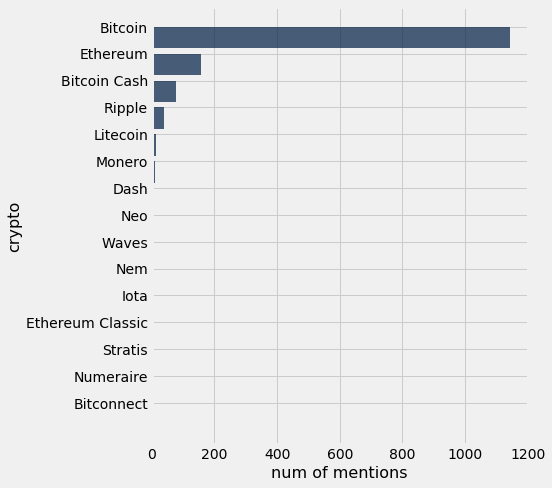

In [178]:
cryptos_num_mentions = cryptos_num_mentions.sort("num of mentions", descending = True)
cryptos_num_mentions.barh('crypto')

Clearly, in recent history, Bitcoin is far and away the most reported on cryptocurrency by Coindesk.

In order to do the same for the categorical variable, we'll first group the table. The result will be a table that shows the amount of cryptocurrencies that recieved negative, positive and neutral sentiments from Coindesk. 

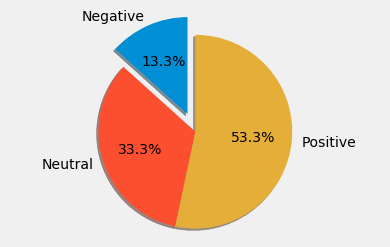

In [179]:
grouped = cryptos_sentiments.group("general sentiment") 

fig1, ax1 = plots.subplots() #all code is almost exactly copied from pyplot's documentation
labels = grouped.column("general sentiment")
explode = (.2, 0, 0)
sentiments = grouped.column("count")


ax1.pie(sentiments, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  

plots.show()


As would make sense for a business based on cryptocurrencies, Coindesk has about five times as many  positive sentiments on cryptocurrencies than it does negative. It is important to take into account, that this is only a small, 15-cryptocurrency sample, the actual pie chart of the entire population would have a significantly larger neutral slice as there are hundreds of cryptocurrencies, and it is nearly impossible that Coindesk could get the opportunity to tweet on all of them. 

## 5. Joining tables

Now, let's add in the part everyone actually cares about, the price! We'll do so by creating a new table for the prices and then joining all of the existing tables. 

Note: prices from https://coinmarketcap.com/ on 11/28/2017 at approximately 3:47 P.M.

In [202]:
#Creating new table for prices
prices = make_array(10084.40, 472.24, 0.301084, 1552.62, 285.63, 627.05, 34.02, 1.48, 95.53, 198.75, 0.249141, 38.38, 15.31, 6.41, 5.83) 
crypto_prices = Table().with_columns( "crypto", cryptos, 
                                    "price", prices)

#Joining all existing data
existing_data = cryptos_sentiments.join("crypto", cryptos_num_mentions)
crypto_data = existing_data.join("crypto", crypto_prices)

crypto_data

crypto,general sentiment,num of mentions,price
Bitcoin,Positive,1142,10084.4
Bitcoin Cash,Positive,76,1552.62
Bitconnect,Neutral,0,285.63
Dash,Positive,5,627.05
Ethereum,Positive,156,472.24
Ethereum Classic,Positive,1,34.02
Iota,Neutral,1,1.48
Litecoin,Positive,14,95.53
Monero,Positive,9,198.75
Nem,Neutral,1,0.249141


It is important to note that one could not have simply used with_column on prices, as the order of the cryptocurrencies might have been different, since we sorted one of the tables before creating the bar graph. If the order were thrown off that would have horrible ramifications on our interpretation of the data.    

## 6. Hypothesizing

Creating a hypothesis and testing it is what data science is the value of data science! For the sake of simplicity, let's choose a basic hypothesis to be able to test.

**Null Hypothesis:** There is no relationship between the price of a cryptocurrency and the number of times that Coindesk will mention it. 

**Alternative Hypothesis:** The larger a cryptocurrency's price, the more mentions it will get from Coindesk. 


## 7. Testing the hypothesis

In order to test this hypotheis, we will do the following:
1. <font color = 'blue'> Calculate the correlation of the relationship. </font> 
2. <font color = 'blue'>  Calculate the probability that this correlation would have occurred. </font>
3. <font color = 'blue'> We will use a <font color = 'gold'>p-value cutoff of 5% </font>, meaning that this <font size = '4'> **correlation is only significant if there is a less than 5% chance that this correlation would be this high.** </font> </font>


In [216]:
x = crypto_data.column("price")
y = crypto_data.column("num of mentions")
'''
def standard_units(nums):
    """Return an array where every value in nums is converted to standard units."""
    return (nums - np.mean(nums)) / np.std(nums) 

r = np.average(standard_units(x) * standard_units(y))
'''

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y) 
if p_value < .05:
    print("There is a correlation, " + str(r_value) + ", and it's statistically significant!")
else: 
    print("Looks like any tiny correlation here is statistically insignificant.")

There is a correlation, 0.988537722621, and it's statistically significant!


Yay!! We can reject the null hypothesis, there actually was a correlation where we though there was. Now, it's time for something a little more advanced.

## 8-10. Using Machine Learning to predict Bitcoin Price

We can begin by stating a major disclaimer about these predictions. As everyone knows, this is an incredibly volatile market, and the machine learning algorithm we're using through SciPy is a linear regression. However, as you can see in the sample below, a linear relationship might not be the best way to describe the changes in crypto prices over time. As well, the practice of predicting future prices based off of past prices is one that's been oft-used but never confirmed a scientific method of predicting performance.  
<font color = 'white'> 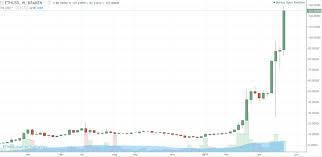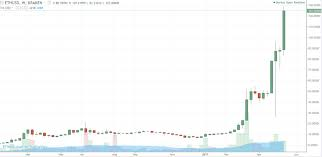
</font>

The prediction technique we're applying is machine learning, using Scikit Learn. The reason one would choose this prediction technique is that it goes beyond a simple linear regression, rather it takes a set of variables, and uses an algorithm developed with these variables to predict the future. This is clearly superior to basic linear regression because basic linear regression only uses one value to predict. 

In [307]:
bitcoin = Table.read_table("bitcoin.csv") #retrieved from Quandl: includes: Date, Open, High, Low, Close, Volume (BTC), Volume (Currency), Weighted Price 
bitcoin

Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2013-03-31,93.25,100,93.03,93.1,390.827,37089.3,94.8996
2013-04-01,93.17,105.9,92.5,102.37,4919.65,492101,100.028
2013-04-02,102.8,118.388,99,117.99,9084.83,987412,108.688
2013-04-03,116.579,146.88,101.511,134.953,12909.4,1.65209e+06,127.976
2013-04-04,131.78,143,119,132.681,6910.1,909439,131.61
2013-04-05,132.75,145,131.503,140,4838.18,669393,138.356
2013-04-06,141,144,140.902,143.99,2170.75,310411,142.997
2013-04-07,144,174.4,143.501,174.4,3735.13,583658,156.262
2013-04-08,172.51,200,166.693,194.5,10616.3,1.93504e+06,182.271
2013-04-09,190.51,249.97,188.898,233.115,6188.92,1.36307e+06,220.244


In [315]:
#creating a couple of factors like volatility and percent_daily_change in order to help the machine learning
#algorithm have access to more useful variables 

volatility = (bitcoin.column("High") - bitcoin.column("Close")) /  bitcoin.column("Close") * 100
bitcoin.with_column('Volatility (%)', volatility)

percent_daily_change = bitcoin.column("Close") - bitcoin.column("Open") / bitcoin.column("Open") * 100
bitcoin.with_column('Daily Change(%)', percent_daily_change)

bitcoin 

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Future
2013-03-31,93.25,100,93.03,93.1,390.827,37089.3,94.8996,95
2013-04-01,93.17,105.9,92.5,102.37,4919.65,492101,100.028,78.001
2013-04-02,102.8,118.388,99,117.99,9084.83,987412,108.688,70.11
2013-04-03,116.579,146.88,101.511,134.953,12909.4,1.65209e+06,127.976,91.797
2013-04-04,131.78,143,119,132.681,6910.1,909439,131.61,114.28
2013-04-05,132.75,145,131.503,140,4838.18,669393,138.356,116.95
2013-04-06,141,144,140.902,143.99,2170.75,310411,142.997,126
2013-04-07,144,174.4,143.501,174.4,3735.13,583658,156.262,121
2013-04-08,172.51,200,166.693,194.5,10616.3,1.93504e+06,182.271,127.596
2013-04-09,190.51,249.97,188.898,233.115,6188.92,1.36307e+06,220.244,145.9


In [309]:
#Establishing future prices 

predicting_col = 'Close' 

daysback = 0.01 #how far in the future we'd like to predict (in our case 1% based on data sample)
future_days = int(math.ceil(daysback * bitcoin.num_rows)) 
print("We want to predict", str(future_days), "days in the future") 

future_prices = np.roll(bitcoin.column(predicting_col), bitcoin.num_rows - future_days) 

bitcoin = bitcoin.with_column("Future", future_prices) #The prices 1% in the future from any given data point

bitcoin = bitcoin.take(range(0, bitcoin.num_rows - future_days)) # no longer want the last 14 rows because they'll be false

bitcoin

We want to predict 14 days in the future


Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Future
2013-03-31,93.25,100,93.03,93.1,390.827,37089.3,94.8996,95
2013-04-01,93.17,105.9,92.5,102.37,4919.65,492101,100.028,78.001
2013-04-02,102.8,118.388,99,117.99,9084.83,987412,108.688,70.11
2013-04-03,116.579,146.88,101.511,134.953,12909.4,1.65209e+06,127.976,91.797
2013-04-04,131.78,143,119,132.681,6910.1,909439,131.61,114.28
2013-04-05,132.75,145,131.503,140,4838.18,669393,138.356,116.95
2013-04-06,141,144,140.902,143.99,2170.75,310411,142.997,126
2013-04-07,144,174.4,143.501,174.4,3735.13,583658,156.262,121
2013-04-08,172.51,200,166.693,194.5,10616.3,1.93504e+06,182.271,127.596
2013-04-09,190.51,249.97,188.898,233.115,6188.92,1.36307e+06,220.244,145.9


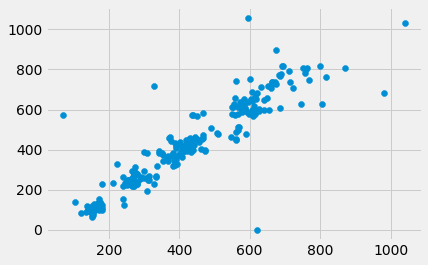

In [337]:
y = np.array(bitcoin.column("Future")) #ultimate result 

bitcoin_predictors = bitcoin.drop(["Date","Future"]) #dropping features we don't want for predicting y 

row_count = bitcoin_predictors.num_rows
col_count = bitcoin_predictors.num_columns

X = np.zeros(shape = (row_count, col_count)) # create and populate X, the features that are used to determine y 
for row in range(row_count): 
    arr = np.array(bitcoin_predictors.row(row))
    X[row] = arr

#Below, what we're doing is taking 80% of the data we have, and using it as training, develop a classifier
#20% are then used for testing once we've developed that classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) 

classifier = LinearRegression() #classifier before training
classifier.fit(X_train,y_train) #trains classifier 

forecast_set = classifier.predict(X_test)

plots.scatter(forecast_set, y_test)

In [338]:
accuracy = classifier.score(X_test, y_test) # correlation of the above scatter plot
print(accuracy)

0.847864549288


Using Machine Learning helped us to get an accuracy score of 84.7%. The reason that this was so much more accurate than a straight up linear regression of closing price against time, is that machine learning enbales a computer to create its own algorithms based on a multitude of variables, not just one.

In [339]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'exploration.ipynb'.
Submit... 100% complete
Submission successful for user: maxmiranda@berkeley.edu
URL: https://okpy.org/cal/data8/fa17/exploration/submissions/Y655NK

